In [9]:
import numpy as np
import cv2
import pathlib
import os

    
def color_extraction(img):

    # 画像中の色（固定）
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                         [255,255,0],[255,0,255],[0,255,255],
                         [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)

    masks = np.ones((img.shape[0], img.shape[1], 9), dtype=np.uint8)
    it = 0

        # 色ごとにチャンネルを分ける
    for i in color_arr:
        lower = np.clip(i, 0, 255)
        upper = np.clip(i, 0, 255)
        img_mask = cv2.inRange(img, lower, upper)
        masks[:,:,it] = img_mask
        it += 1
        
        return masks

def mask_contours(img):

    contour_list = []

    # 色ごとに輪郭（閉曲線）を抽出
    masks = color_extraction(img)
    for i in range(masks.shape[2]):
        contours, hierarchy = cv2.findContours(masks[:,:,i],cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        contour_list.append(contours)

    return contour_list


def split_list(contour_length, max_frag_len=100, min_frag_len=40, min_overrap=10):
    
    # 輪郭のフラグメントの位置を指定(最小40 pixl)
    if contour_length > max_frag_len:
        pass
    
    elif contour_length < 40:
        return None
    
    elif contour_length == 40:
        return [0,39]
    
    else:
        max_frag_len = contour_length
    
    step0 = np.random.randint(min_frag_len, max_frag_len) # 一つ目のフラグメントの長さ（40から100）
    frag_list = [[0,step0]]
    back = np.random.randint(min_overrap, step0-1) # フラグメントを重ねるために戻す分を決める（最小10 pixl）
    next_start = step0 - back
    
    while True:
        
        # 戻った分(back)より進む
        if back+1 > min_frag_len:
            step = np.random.randint(back+1, max_frag_len)
        else:
            step = np.random.randint(min_frag_len, max_frag_len)

        full_length = next_start + step
        frag = [next_start, full_length]
        frag_list.append(frag)
        back = np.random.randint(10, step-1)
        next_start = full_length - back

        # 終了判定
        if full_length > contour_length:
            break
    
    # 超過した分戻す（長さはそのまま）
    difference = frag_list[-1][1] - (contour_length-1)
    frag_list[-1][0] -= difference
    frag_list[-1][1] -= difference
    
    return frag_list


def contours_split(contour):
    
    #contour.shape == (N, 2)
    contour_length = contour.shape[0]
    sp_list = split_list(contour_length)
    
    if sp_list == None:
        return None
    
    frag_list = []
    
    # 位置のリスト通りにスライス
    for sp in sp_list:

        frag_list.append(contour[sp[0]:sp[1],:])
        
    return frag_list


def contours2fragments(contours_list):
    
    # 輪郭のリストからフラグメントのリストを得る
    frags_list = []

    for i in contours_list:
        temp_list = []
        frags = []
        for j in i:
            temp_frags = contours_split(j.squeeze())
            
            if temp_frags != None:
                frags += temp_frags

        if frags != []:
            frags_list.append(frags)
    
    return frags_list


def coodinate2image(frags_list, y=1080, x=1920):
    
    
    # 座標を画像化
    frags_img = []

    for colors in frags_list:
        temp_col_list = []

        for frag in colors:
            temp_frag_img = np.zeros((y, x))

            for coordinate in frag:
                temp_frag_img[coordinate[1]][coordinate[0]] = 1

            temp_col_list.append(temp_frag_img)

        frags_img.append(temp_col_list)
        
    return frags_img


def paths_sorted(paths):
    return sorted(paths, key = lambda x: int(x.stem))


def vmat_csv_read(folder):
    
    folder_path = pathlib.Path(folder)
    files = list(folder_path.glob("*.csv"))
    sorted_files = paths_sorted(files)
    
    Rtmats=[]
    
    for file in sorted_files:
        Rtmats.append(np.loadtxt(file, delimiter="\t"))
    return Rtmats


# 内部パラメータ(unityカメラの初期値)
f = 8000/3
cx = 1920/2
cy = 1080/2

A = np.zeros((3,3))
A[0,0] = f
A[0,2] = cx
A[1,1] = f
A[1,2] = cy
A[2,2] = 1

def T_mat(t_vec):

    t_vec = np.squeeze(t_vec)
    T = np.zeros((3, 3))
    T[0,1] = -t_vec[2]
    T[0,2] = t_vec[1]
    T[1,0] = t_vec[2]
    T[1,2] = -t_vec[0]
    T[2,0] = -t_vec[1]
    T[2,1] = t_vec[0]
    
    return T


def F_mat(A1, A2, Rt1, Rt2):
    
    R1 = Rt1[0:3, 0:3]
    R2 = Rt2[0:3, 0:3]
    t1 = Rt1[0:3,3]
    t2 = Rt2[0:3,3]
    #print(R1, R2, t1, t2)
    R = np.dot(R1.T, R2)
    t = np.dot(R1.T, t1-t2)
    T = T_mat(t)
    
    F = np.dot(np.dot(np.dot(np.linalg.inv(A1).T, T), R), np.linalg.inv(A2))
    
    return F


def epilines_para(frags, F):
    
    lines2_list = []
    for color in frags:
        temp_color_list = []
        for frag in color:
            frag_lines = cv2.computeCorrespondEpilines(frag.reshape(-1,1,2), 1,F) # ndarray(フラグメントの座標数,1,3)
            temp_color_list.append(frag_lines)

        lines2_list.append(temp_color_list)
    
    return lines2_list


def para2line(parameter):
    
    #一つのパラメータが渡された時を想定
    line_coode = np.zeros((1920,2), dtype=np.int64)
    para = np.squeeze(parameter)# 3次ベクトル
    for x in range(1920):
        y = int((-para[0]*x - para[2])/para[1])
        line_coode[x,0] = x
        line_coode[x,1] = y
    
    return line_coode


def epiline_cal(frag_paras):
    #全ての色に対するエピポーラ線の帯の計算
    #lines[色][フラグメント][線][座標]
    lines = []
    for color in frag_paras:
        temp_color = []
        
        for frag in color:
            temp_line = []

            for point in frag:
                line = para2line(point)
                temp_line.append(line)

            temp_color.append(temp_line)
        lines.append(temp_color)
        
    return lines2_list


def frag_vs_line(img2_frags, frag_epiline):
    
    # frag_epiline shape(1920, 2)
    surport = np.zeros(len(img2_frags))
    for i in frag_epiline:
        for j, frag in enumerate(img2_frags):
            if i in frag:
                surport[j] += 1
    
    return surport


def pair_frag_idx(img2_frags, frag_epilines):
    surport = np.zeros(len(img2_frags))
    for epi in frag_epilines:
        surport += frag_vs_line(img2_frags, epi)
        
    return np.argmax(surport)




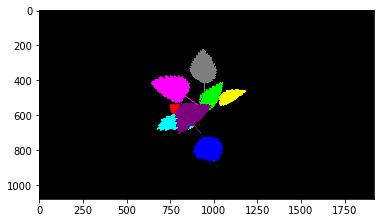

In [10]:
import matplotlib.pyplot as plt

img1 = cv2.imread('test1.png',1)# BGRで読み込み
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # RGBに変換

plt.imshow(img1)

In [11]:
img1.shape

(1080, 1920, 3)

In [12]:
c_list = mask_contours(img1) # 輪郭のリスト
frags = contours2fragments(c_list) # フラグメント化
frags_img = coodinate2image(frags) # 座標を画像化
vmat = vmat_csv_read("view_matrix/") # 外部パラメータ読み込み

In [13]:
F = F_mat(A, A, vmat[10], vmat[11]) # Fを計算

In [14]:
paras = epilines_para(frags, F) #エピ極線のパラメータを計算

In [ ]:
lines = epiline_cal(paras)

(-0.5, 1919.5, 1079.5, -0.5)

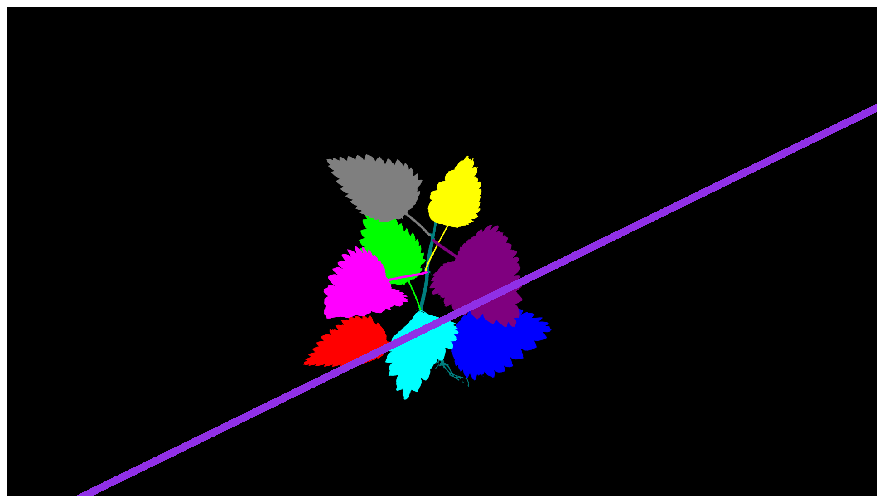

In [25]:
img2 = cv2.imread('test2.png',1)# BGRで読み込み
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # RGBに変換
color = tuple(np.random.randint(0,255,3).tolist())

img2 = cv2.line(img2, tuple(lines[0][0][0][0]), tuple(lines[0][0][0][-1]),color,15)


plt.figure(figsize=(16, 9))
plt.imshow(img2)
plt.axis("off")

In [31]:
img2_c_list = mask_contours(img2) # 輪郭のリスト
img2_frags = contours2fragments(img2_c_list) # フラグメント化

In [49]:
img2_frags[0]

[array([[830, 766],
        [829, 767],
        [828, 767],
        [827, 768],
        [826, 768],
        [825, 769],
        [824, 769],
        [823, 770],
        [822, 770],
        [821, 771],
        [820, 771],
        [819, 772],
        [818, 772],
        [817, 773],
        [816, 773],
        [815, 774],
        [814, 774],
        [813, 775],
        [812, 775],
        [811, 776],
        [810, 776],
        [809, 776],
        [808, 777],
        [807, 777],
        [806, 778],
        [805, 778],
        [804, 779],
        [803, 779],
        [802, 780],
        [801, 780],
        [800, 781],
        [799, 781],
        [798, 782],
        [797, 782],
        [798, 782],
        [799, 782],
        [800, 782],
        [801, 782],
        [802, 781],
        [803, 781],
        [804, 780],
        [805, 780]], dtype=int32),
 array([[823, 770],
        [822, 770],
        [821, 771],
        [820, 771],
        [819, 772],
        [818, 772],
        [817, 773],
     

In [47]:
len(lines[0][0][0])

1920

In [80]:
pair_frag_idx(img2_frags[0], lines[0][0])

13

# つながっているか
for i in range(c_list[4][0].squeeze().shape[0] - 1):
    now = c_list[4][0].squeeze()[i]
    nx = c_list[4][0].squeeze()[i+1]
    if abs(nx[0]-now[0]) > 1 or abs(nx[1]-now[1]) > 1:
        print(nx[0]-now[0],nx[1]-now[1])
        print("繋がっていない")
        break

print("繋がっている")

fst = c_list[0][0].squeeze()[0]
last = c_list[0][0].squeeze()[-1]

if abs(fst[0]-last[0]) > 1 or abs(fst[1]-last[1]) > 1:
    print("閉じてない")
else:
    print("閉じてる")